In [70]:
# !pip install torchsummary
# !pip install torchview

# Import standard libraries
import numpy as np
import pandas as pd
import os
import random
import gc
import warnings
warnings.filterwarnings('ignore')

# Importing visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Importing audio processing libraries
import librosa
import librosa.display
import soundfile as sf
import IPython.display as ipd

# Importing PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchview import draw_graph

# Importing sklearn libraries
from sklearn.model_selection import StratifiedShuffleSplit

# For progress tracking
from tqdm.notebook import tqdm, trange

# Set a seed for reproducibility
SEED = 42
def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
seed_everything()

You should consider upgrading via the '/Users/saahil/Desktop/Coding_Projects/Audio/test-audio/env1/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/saahil/Desktop/Coding_Projects/Audio/test-audio/env1/bin/python3 -m pip install --upgrade pip' command.


In [71]:
# Loading the metadata
metadata = pd.read_csv('archive-3/esc50.csv')

# Displaying the first few rows
metadata.head()


filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A

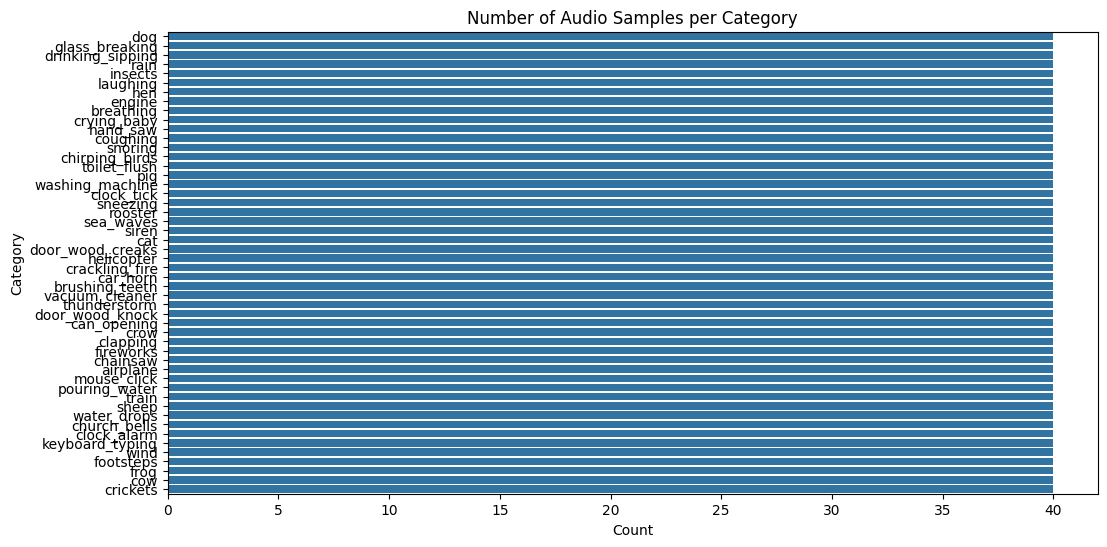

In [72]:
# Plotting the distribution of categories
plt.figure(figsize=(12, 6))
sns.countplot(y='category', data=metadata, order=metadata['category'].value_counts().index)
plt.title('Number of Audio Samples per Category')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()


In [73]:
# Loading an audio file
sample_file = 'archive-3/audio/audio/1-137-A-32.wav'
audio_data, sample_rate = librosa.load(sample_file)
print(f'Sample Rate: {sample_rate}')
print(f'Audio Shape: {audio_data.shape}')
print(f'Duration: {len(audio_data)/sample_rate} seconds')

# Play the audio
ipd.Audio(sample_file)


Sample Rate: 22050
Audio Shape: (110250,)
Duration: 5.0 seconds


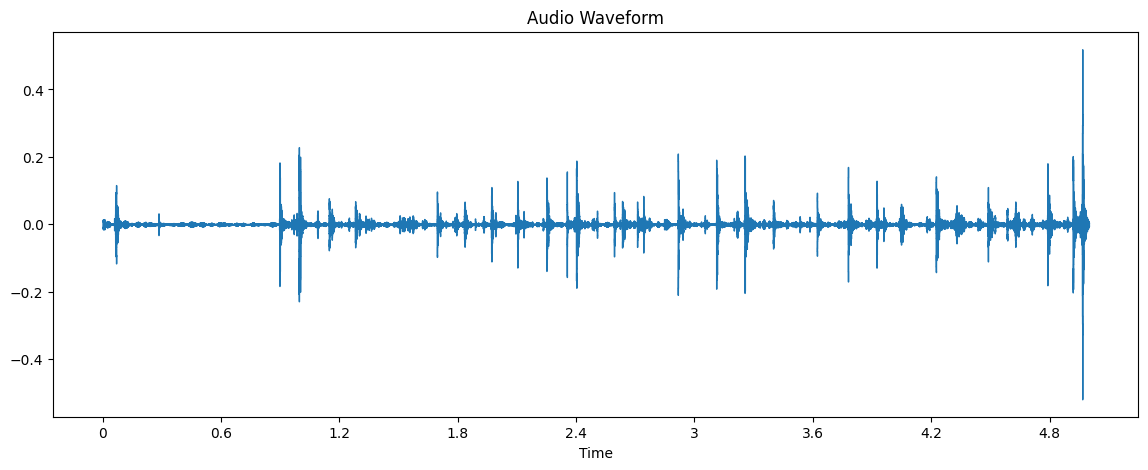

In [74]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio_data, sr=sample_rate)
plt.title('Audio Waveform')
plt.show()


In [75]:
# A decoder dictionary
decoder = dict(zip(metadata['target'], metadata['category']))

# List of all audio file paths
audio_dir = 'archive-3/audio/audio'
all_files = [os.path.join(audio_dir, file) for file in metadata['filename']]

# Randomly select 9 audio files
import random
random_files = random.sample(all_files, 9)


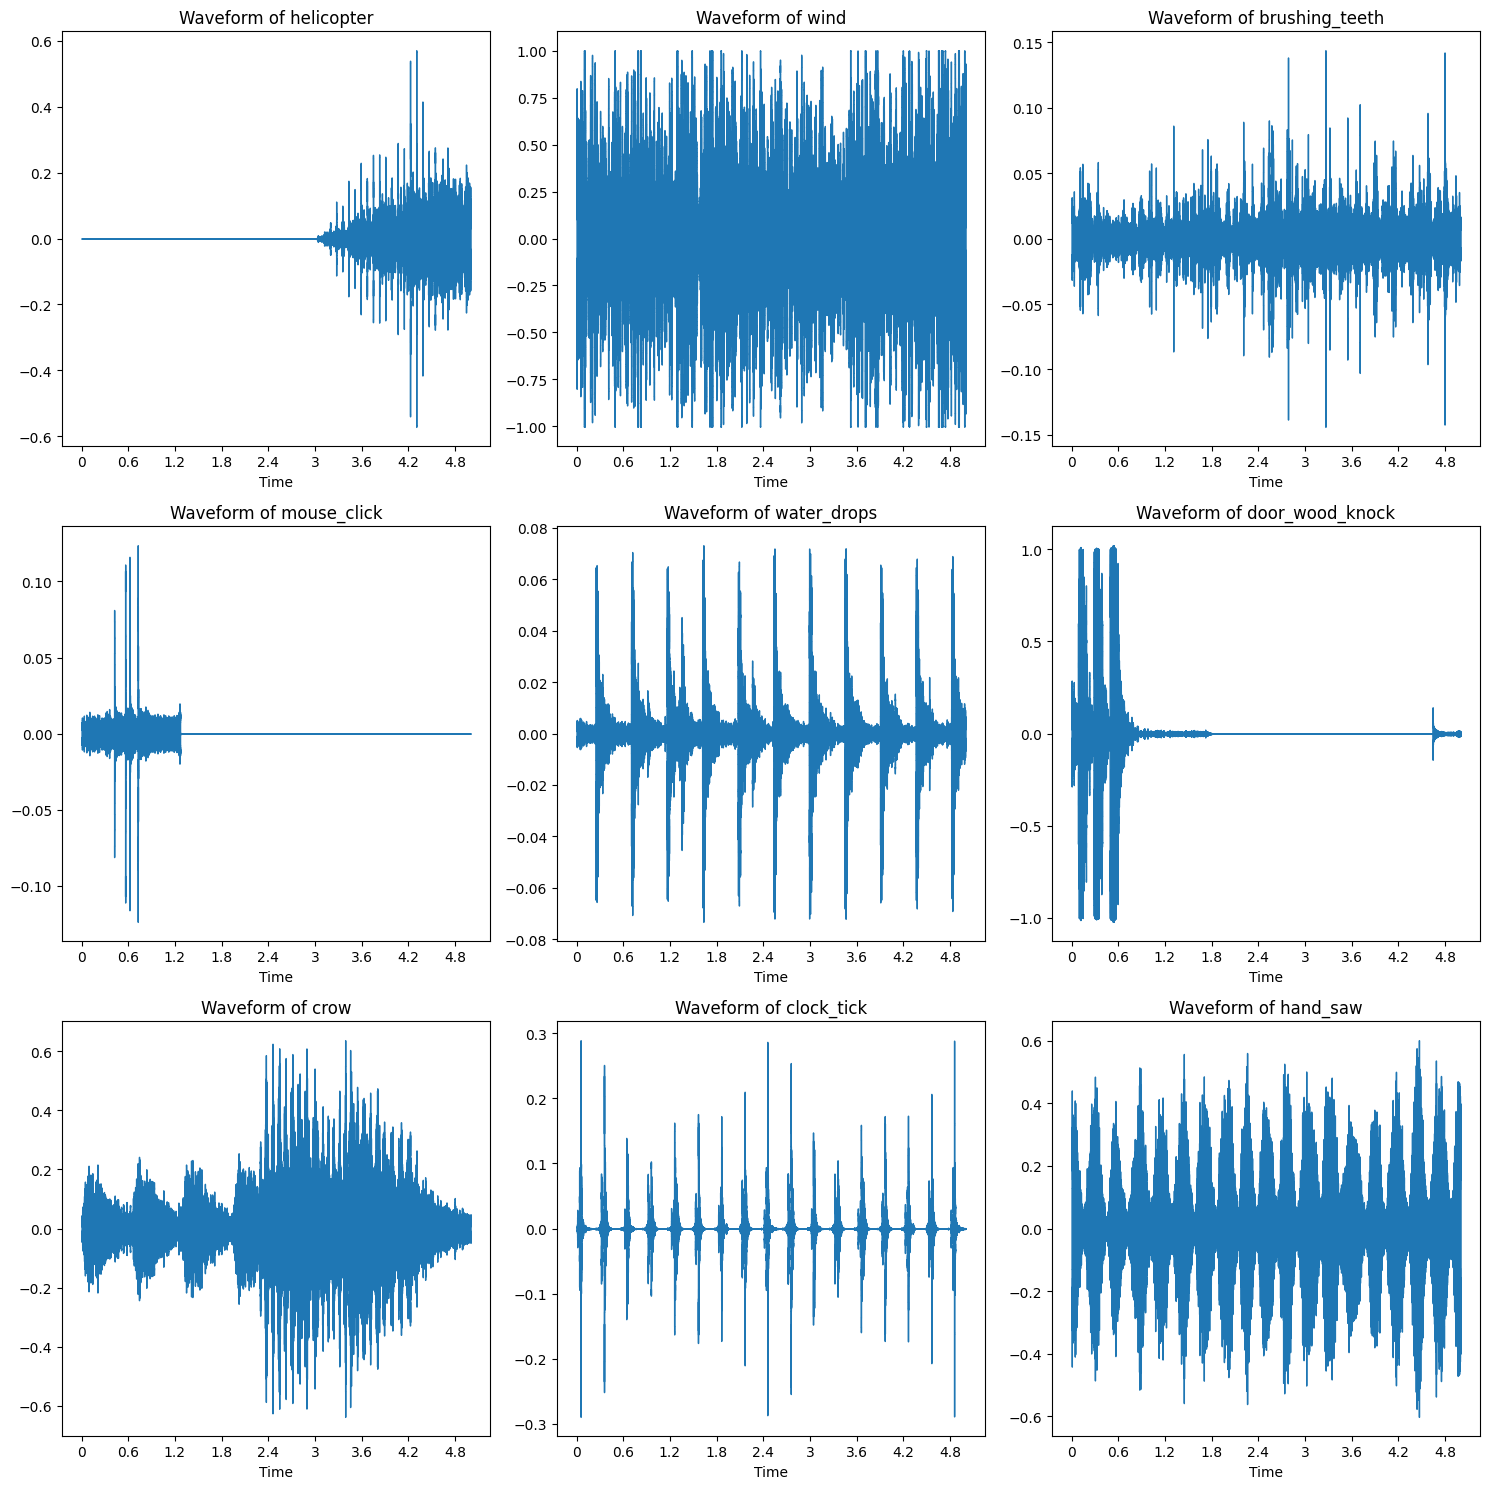

In [76]:
plt.figure(figsize=(15, 15))
for idx, file in enumerate(random_files):
    
    data, sr = librosa.load(file)
    
    # The target label from the filename
    filename = os.path.basename(file)
    target = metadata[metadata['filename'] == filename]['target'].values[0]
    category = decoder[target]
    
    # Waveform
    plt.subplot(3, 3, idx+1)
    librosa.display.waveshow(data, sr=sr)
    plt.title(f'Waveform of {category}')
    plt.tight_layout()
plt.show()


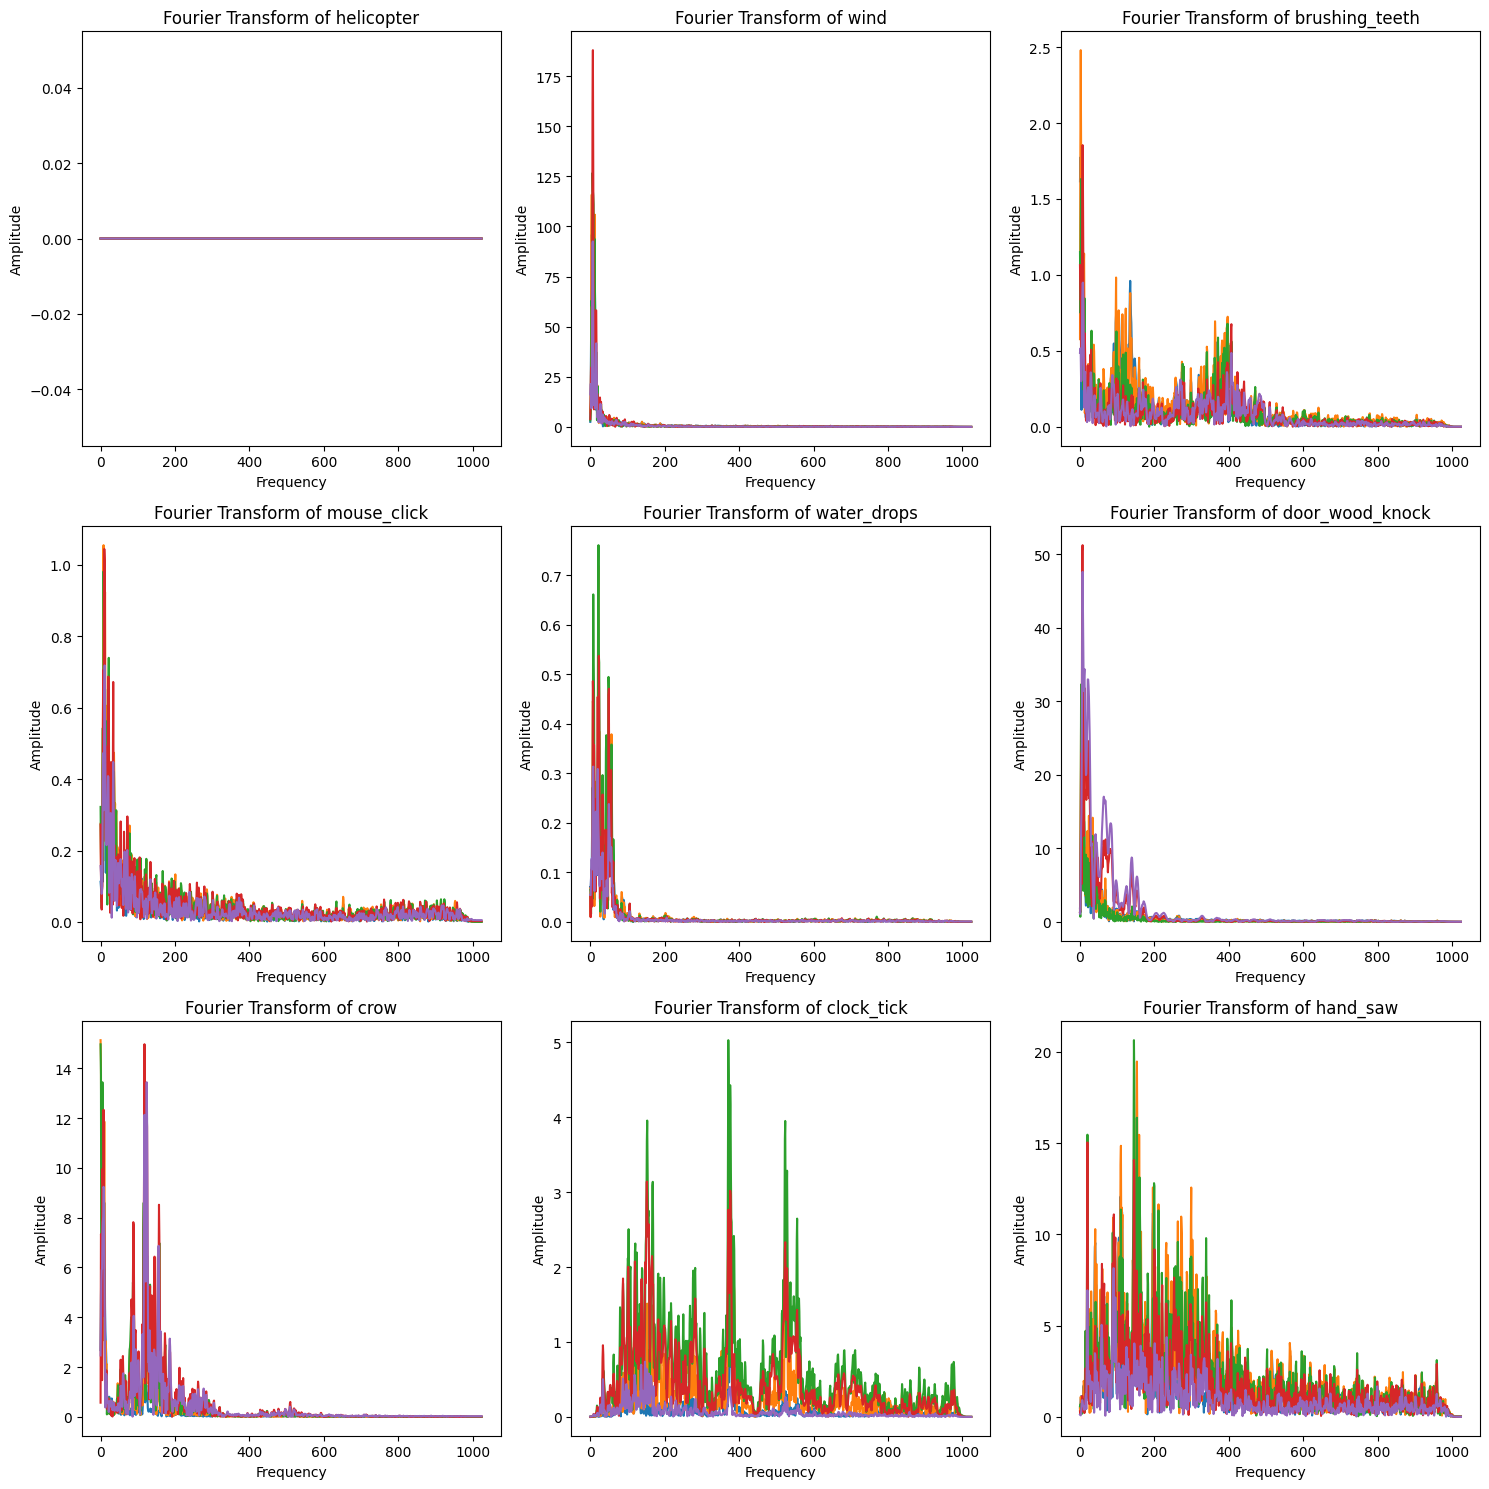

In [77]:
plt.figure(figsize=(15, 15))
for idx, file in enumerate(random_files):
    
    data, sr = librosa.load(file)
    
    # Fourier Transform
    n_fft = 2048
    D = np.abs(librosa.stft(data[:n_fft]))
    
  
    filename = os.path.basename(file)
    target = metadata[metadata['filename'] == filename]['target'].values[0]
    category = decoder[target]
    
    # Plotting Fourier Transform
    plt.subplot(3, 3, idx+1)
    plt.plot(D)
    plt.title(f'Fourier Transform of {category}')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.tight_layout()
plt.show()


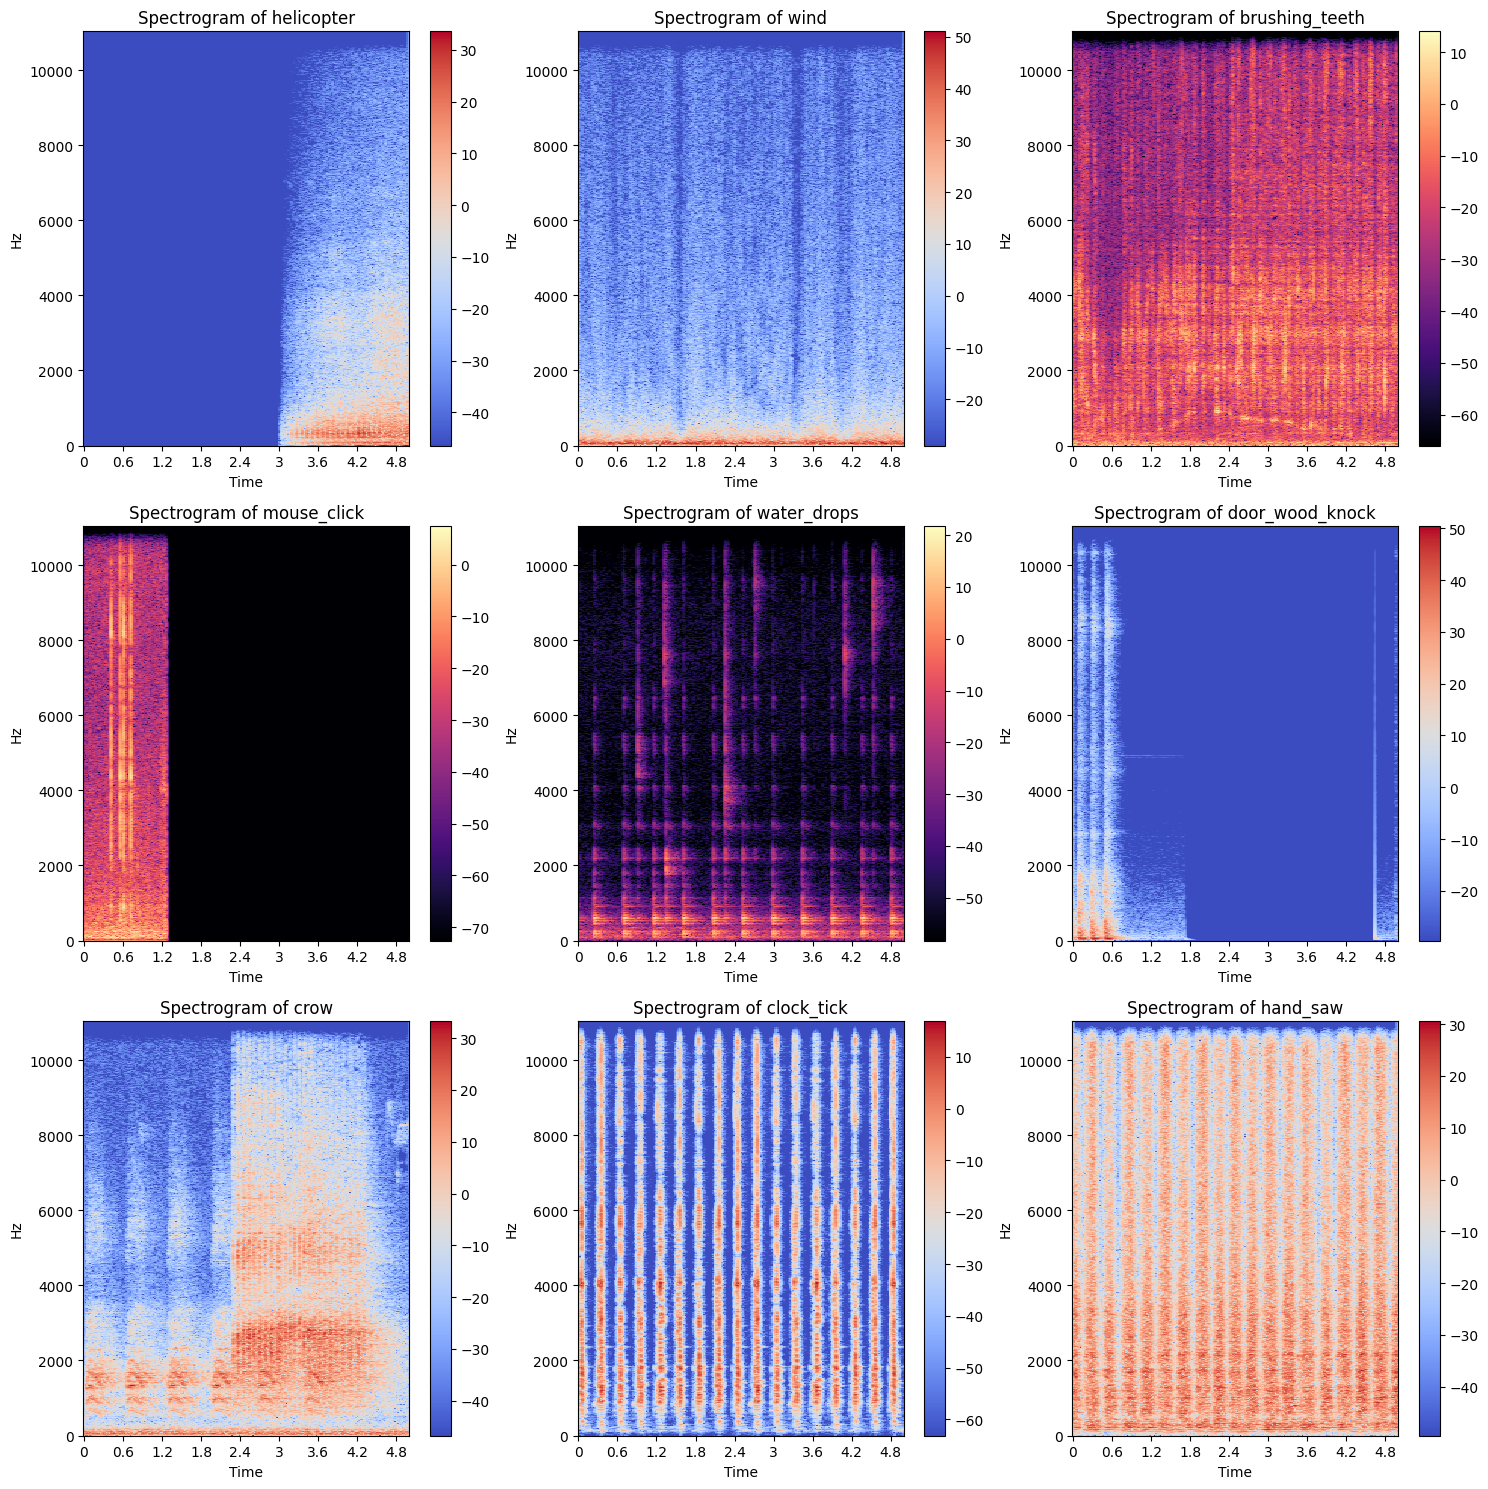

In [78]:
plt.figure(figsize=(15, 15))
for idx, file in enumerate(random_files):
    
    data, sr = librosa.load(file)
    
    # Computing Spectrogram
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
   
    filename = os.path.basename(file)
    target = metadata[metadata['filename'] == filename]['target'].values[0]
    category = decoder[target]
    
    # Plotting Spectrogram
    plt.subplot(3, 3, idx+1)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.title(f'Spectrogram of {category}')
    plt.tight_layout()
plt.show()


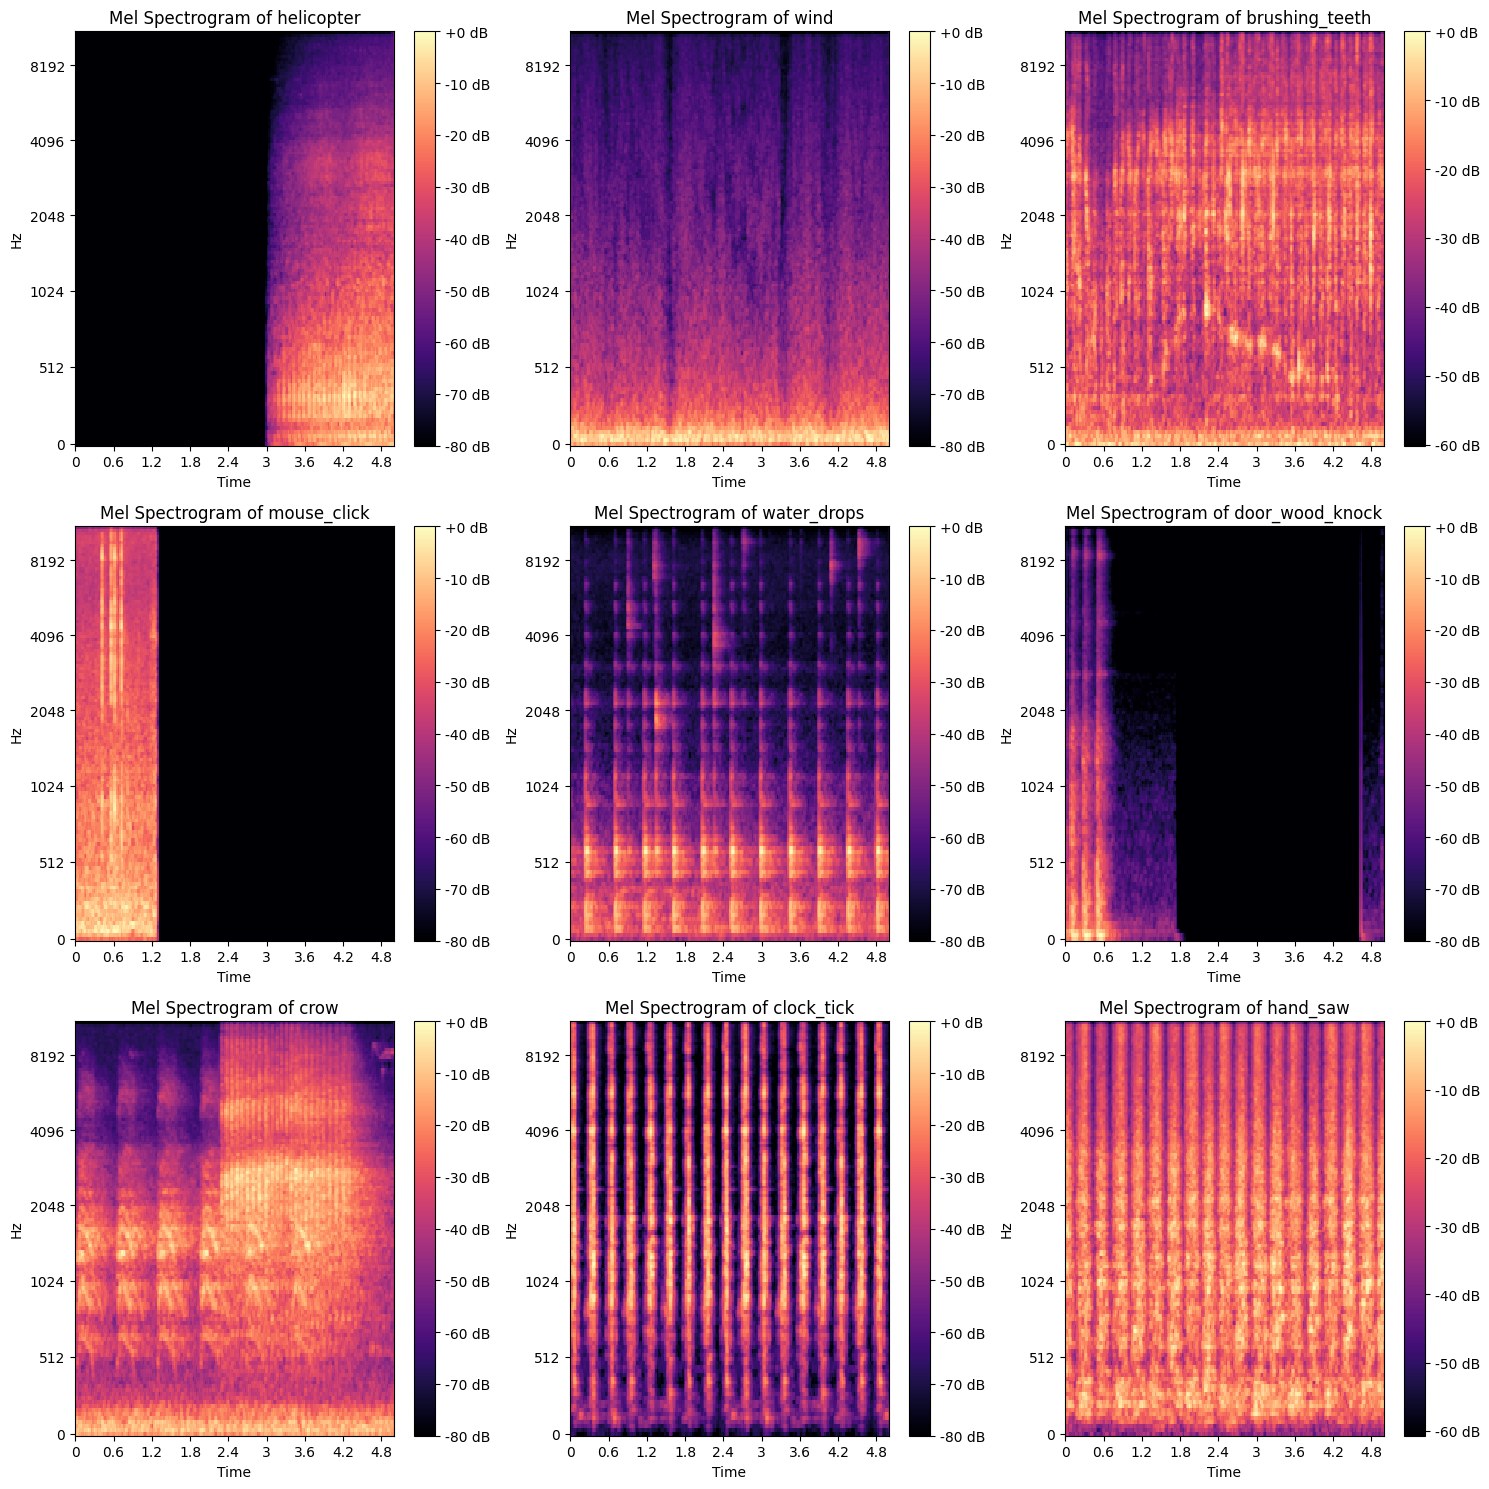

In [79]:
plt.figure(figsize=(15, 15))
for idx, file in enumerate(random_files):
    
    data, sr = librosa.load(file)
    
    S = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    
    
    filename = os.path.basename(file)
    target = metadata[metadata['filename'] == filename]['target'].values[0]
    category = decoder[target]
    
    # Plotting Mel Spectrogram
    plt.subplot(3, 3, idx+1)
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel Spectrogram of {category}')
    plt.tight_layout()
plt.show()


In [80]:
def add_noise(data, noise_factor=0.005):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    return augmented_data

def time_shift(data, shift_max=0.2):
    shift = np.random.randint(int(sample_rate * shift_max))
    direction = np.random.choice([-1, 1])
    shift = shift * direction
    augmented_data = np.roll(data, shift)
    return augmented_data

def time_stretch_torchaudio(data, rate=1.0):
    # Numpy array to tensor
    data_tensor = torch.from_numpy(data)
    # + batch and channel dimensions
    data_tensor = data_tensor.unsqueeze(0).unsqueeze(0)
    # Spectrogram
    spectrogram = torchaudio.transforms.Spectrogram()(data_tensor)
    # Applying time stretching
    stretched_spectrogram = torchaudio.transforms.TimeStretch(fixed_rate=rate)(spectrogram)
    # Inversing spectrogram to get back to time domain
    stretched_data = torchaudio.transforms.InverseSpectrogram()(stretched_spectrogram)
    # Removing batch and channel dimensions
    stretched_data = stretched_data.squeeze().numpy()
    return stretched_data

def pitch_shift_torchaudio(data, sample_rate, n_steps):
    data_tensor = torch.from_numpy(data).float()
    if data_tensor.ndim == 1:
        data_tensor = data_tensor.unsqueeze(0)
    pitch_shift_transform = torchaudio.transforms.PitchShift(sample_rate, n_steps=n_steps)
    shifted_data = pitch_shift_transform(data_tensor)
    # Detaching the tensor before converting to NumPy
    shifted_data = shifted_data.squeeze().detach().numpy()
    return shifted_data


# # Example of data augmentation
# augmented_data = add_noise(audio_data)


In [81]:
def pad_or_truncate_spectrogram(spectrogram, max_frames):
    if spectrogram.shape[1] < max_frames:
        # Padding with zeros on the time axis
        pad_width = max_frames - spectrogram.shape[1]
        padded_spectrogram = np.pad(spectrogram, ((0, 0), (0, pad_width)), mode='constant')
    else:
        # Truncating to the fixed number of frames
        padded_spectrogram = spectrogram[:, :max_frames]
    return padded_spectrogram


In [82]:
    # def extract_features(data):
    #     mel_spectrogram = librosa.feature.melspectrogram(y=data, sr=sample_rate, n_mels=128)
    #     mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    #     return mel_spectrogram_db

def extract_features(data, sr, max_frames):

        mel_spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128)
        # Normalizing
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        # Padding or truncating
        mel_spectrogram_db = pad_or_truncate_spectrogram(mel_spectrogram_db, max_frames)
        
        mean = np.mean(mel_spectrogram_db)
        std = np.std(mel_spectrogram_db)
        mel_spectrogram_db = (mel_spectrogram_db - mean) / std
        return mel_spectrogram_db

    # Extracting features from the sample audio
sample_rate = 22050
# features = extract_features(audio_data,sample_rate,max_frames=512)



In [83]:
# features_list = []
# labels_list = []

# # Looping through the dataset and extract features
# for index, row in tqdm(metadata.iterrows(), total=metadata.shape[0]):
#     file_path = os.path.join('archive-3/audio', 'audio', row['filename'])
#     class_label = row['target']
#     data, _ = librosa.load(file_path, sr=sample_rate)
    
#     # Original features
#     features = extract_features(data)
#     features_list.append(features)
#     labels_list.append(class_label)
    
#     # Augmented data
#     augmented_data = add_noise(data)
#     features_aug = extract_features(augmented_data)
#     features_list.append(features_aug)
#     labels_list.append(class_label)

In [85]:
features_list = []
labels_list = []

sample_rate = 22050  # Define sample rate

# Augmentation methods
augmentations = [
    add_noise,
    time_shift,
    lambda x: time_stretch_torchaudio(x, rate=0.8),
    lambda x: time_stretch_torchaudio(x, rate=1.2),
    lambda x: pitch_shift_torchaudio(x, sample_rate, n_steps=2),
    lambda x: pitch_shift_torchaudio(x, sample_rate, n_steps=-2)
]

# Define max_frames
max_frames = 512

# Looping through the dataset and extract features
for index, row in tqdm(metadata.iterrows(), total=metadata.shape[0]):
    file_path = os.path.join('archive-3/audio', 'audio', row['filename'])
    class_label = row['target']
    
    
    data, sr = librosa.load(file_path, sr=sample_rate)
    
    # Original features
    features = extract_features(data, sr, max_frames=max_frames)
    features_list.append(features)
    labels_list.append(class_label)
    
    # Apply each augmentation
    for aug in augmentations:
        augmented_data = aug(data)
        # Ensuring that time stretching or pitch shifting doesn't produce audio with zero length
        if len(augmented_data) == 0:
            continue
        # Extracting features from augmented data
        features_aug = extract_features(augmented_data, sr, max_frames=max_frames)
        features_list.append(features_aug)
        labels_list.append(class_label)


  0%|          | 0/2000 [00:00<?, ?it/s]

In [86]:
X = np.array(features_list)
y = np.array(labels_list)

# X to match CNN input requirements
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)


In [87]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)


In [88]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# To tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Creating datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Creating dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [93]:
import torch.nn.functional as F

class SoundCNN(nn.Module):
    def __init__(self):
        super(SoundCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.dropout = nn.Dropout(0.3)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(64 * 1 * 1, 128)
        self.fc2 = nn.Linear(128, 50)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2, 2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, (2, 2))
        x = F.relu(self.conv3(x))
        x = self.global_pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # Now x has shape [batch_size, 64*1*1]
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [94]:
model = SoundCNN()
print(model)


SoundCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.3, inplace=False)
  (global_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=50, bias=True)
)


In [95]:
# The loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


SoundCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.3, inplace=False)
  (global_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=50, bias=True)
)

In [96]:
epochs = 150
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(1, epochs + 1):
    # Training
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    print(f'Epoch {epoch}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 1/150, Train Loss: 3.8692, Train Acc: 2.66%, Test Loss: 3.6695, Test Acc: 5.18%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 2/150, Train Loss: 3.6220, Train Acc: 4.94%, Test Loss: 3.5105, Test Acc: 5.00%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 3/150, Train Loss: 3.3846, Train Acc: 8.20%, Test Loss: 3.3422, Test Acc: 8.68%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 4/150, Train Loss: 3.1546, Train Acc: 11.89%, Test Loss: 2.9681, Test Acc: 16.21%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 5/150, Train Loss: 3.0147, Train Acc: 14.63%, Test Loss: 2.8160, Test Acc: 19.89%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 6/150, Train Loss: 2.8307, Train Acc: 18.35%, Test Loss: 2.5946, Test Acc: 25.39%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 7/150, Train Loss: 2.6579, Train Acc: 22.87%, Test Loss: 2.4136, Test Acc: 31.64%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 8/150, Train Loss: 2.5329, Train Acc: 24.99%, Test Loss: 2.2890, Test Acc: 34.04%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 9/150, Train Loss: 2.4201, Train Acc: 28.05%, Test Loss: 2.1713, Test Acc: 37.50%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 10/150, Train Loss: 2.3386, Train Acc: 30.56%, Test Loss: 2.0720, Test Acc: 40.61%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 11/150, Train Loss: 2.2621, Train Acc: 32.22%, Test Loss: 1.9962, Test Acc: 42.43%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 12/150, Train Loss: 2.1915, Train Acc: 34.66%, Test Loss: 1.9080, Test Acc: 45.18%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 13/150, Train Loss: 2.1366, Train Acc: 35.61%, Test Loss: 1.9033, Test Acc: 43.86%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 14/150, Train Loss: 2.0907, Train Acc: 36.44%, Test Loss: 1.8456, Test Acc: 46.32%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 15/150, Train Loss: 2.0353, Train Acc: 38.25%, Test Loss: 1.7601, Test Acc: 48.21%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 16/150, Train Loss: 2.0079, Train Acc: 38.85%, Test Loss: 1.7404, Test Acc: 48.89%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 17/150, Train Loss: 1.9545, Train Acc: 40.01%, Test Loss: 1.6919, Test Acc: 48.93%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 18/150, Train Loss: 1.9320, Train Acc: 40.88%, Test Loss: 1.6339, Test Acc: 51.61%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 19/150, Train Loss: 1.9019, Train Acc: 40.91%, Test Loss: 1.6477, Test Acc: 50.93%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 20/150, Train Loss: 1.8616, Train Acc: 42.88%, Test Loss: 1.6148, Test Acc: 51.93%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 21/150, Train Loss: 1.8418, Train Acc: 43.45%, Test Loss: 1.5817, Test Acc: 52.68%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 22/150, Train Loss: 1.8119, Train Acc: 43.95%, Test Loss: 1.5561, Test Acc: 53.89%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 23/150, Train Loss: 1.7912, Train Acc: 44.90%, Test Loss: 1.5308, Test Acc: 52.89%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 24/150, Train Loss: 1.7632, Train Acc: 44.94%, Test Loss: 1.4648, Test Acc: 56.25%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 25/150, Train Loss: 1.7406, Train Acc: 45.84%, Test Loss: 1.4897, Test Acc: 55.93%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 26/150, Train Loss: 1.7201, Train Acc: 46.37%, Test Loss: 1.5081, Test Acc: 54.89%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 27/150, Train Loss: 1.7087, Train Acc: 46.94%, Test Loss: 1.4509, Test Acc: 56.61%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 28/150, Train Loss: 1.6920, Train Acc: 47.60%, Test Loss: 1.4211, Test Acc: 57.68%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 29/150, Train Loss: 1.6719, Train Acc: 47.94%, Test Loss: 1.3965, Test Acc: 58.18%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 30/150, Train Loss: 1.6401, Train Acc: 48.54%, Test Loss: 1.3631, Test Acc: 59.86%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 31/150, Train Loss: 1.6409, Train Acc: 48.62%, Test Loss: 1.3589, Test Acc: 58.50%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 32/150, Train Loss: 1.6271, Train Acc: 49.15%, Test Loss: 1.3961, Test Acc: 58.82%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 33/150, Train Loss: 1.6176, Train Acc: 49.05%, Test Loss: 1.3178, Test Acc: 59.82%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 34/150, Train Loss: 1.5909, Train Acc: 50.46%, Test Loss: 1.2885, Test Acc: 61.18%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 35/150, Train Loss: 1.5698, Train Acc: 50.19%, Test Loss: 1.2923, Test Acc: 61.04%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 36/150, Train Loss: 1.5566, Train Acc: 51.09%, Test Loss: 1.2596, Test Acc: 62.61%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 37/150, Train Loss: 1.5625, Train Acc: 50.80%, Test Loss: 1.3029, Test Acc: 60.04%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 38/150, Train Loss: 1.5288, Train Acc: 52.05%, Test Loss: 1.2389, Test Acc: 61.36%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 39/150, Train Loss: 1.5142, Train Acc: 52.25%, Test Loss: 1.2142, Test Acc: 62.96%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 40/150, Train Loss: 1.5050, Train Acc: 52.78%, Test Loss: 1.2156, Test Acc: 63.64%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 41/150, Train Loss: 1.5005, Train Acc: 52.28%, Test Loss: 1.1863, Test Acc: 64.18%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 42/150, Train Loss: 1.4907, Train Acc: 53.17%, Test Loss: 1.1943, Test Acc: 63.79%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 43/150, Train Loss: 1.4707, Train Acc: 53.85%, Test Loss: 1.1774, Test Acc: 63.43%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 44/150, Train Loss: 1.4618, Train Acc: 53.61%, Test Loss: 1.1549, Test Acc: 65.25%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 45/150, Train Loss: 1.4561, Train Acc: 53.82%, Test Loss: 1.1433, Test Acc: 64.93%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 46/150, Train Loss: 1.4403, Train Acc: 54.48%, Test Loss: 1.1207, Test Acc: 66.25%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 47/150, Train Loss: 1.4398, Train Acc: 54.75%, Test Loss: 1.1831, Test Acc: 63.32%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 48/150, Train Loss: 1.4400, Train Acc: 53.88%, Test Loss: 1.1125, Test Acc: 65.82%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 49/150, Train Loss: 1.4058, Train Acc: 55.14%, Test Loss: 1.1016, Test Acc: 67.11%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 50/150, Train Loss: 1.4015, Train Acc: 55.61%, Test Loss: 1.1064, Test Acc: 66.64%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 51/150, Train Loss: 1.3839, Train Acc: 56.31%, Test Loss: 1.0684, Test Acc: 67.93%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 52/150, Train Loss: 1.3863, Train Acc: 55.34%, Test Loss: 1.0729, Test Acc: 67.14%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 53/150, Train Loss: 1.4035, Train Acc: 55.54%, Test Loss: 1.0896, Test Acc: 66.50%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 54/150, Train Loss: 1.3761, Train Acc: 56.08%, Test Loss: 1.0839, Test Acc: 66.04%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 55/150, Train Loss: 1.3756, Train Acc: 56.38%, Test Loss: 1.0550, Test Acc: 67.36%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 56/150, Train Loss: 1.3524, Train Acc: 57.18%, Test Loss: 1.0417, Test Acc: 67.75%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 57/150, Train Loss: 1.3404, Train Acc: 57.04%, Test Loss: 1.0539, Test Acc: 67.36%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 58/150, Train Loss: 1.3373, Train Acc: 57.34%, Test Loss: 1.0227, Test Acc: 68.36%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 59/150, Train Loss: 1.3356, Train Acc: 57.17%, Test Loss: 1.0378, Test Acc: 68.07%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 60/150, Train Loss: 1.3274, Train Acc: 57.85%, Test Loss: 1.0387, Test Acc: 68.21%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 61/150, Train Loss: 1.3244, Train Acc: 58.09%, Test Loss: 1.0515, Test Acc: 68.04%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 62/150, Train Loss: 1.3191, Train Acc: 58.12%, Test Loss: 0.9974, Test Acc: 68.57%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 63/150, Train Loss: 1.3096, Train Acc: 58.43%, Test Loss: 0.9930, Test Acc: 68.36%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 64/150, Train Loss: 1.2872, Train Acc: 59.30%, Test Loss: 0.9963, Test Acc: 69.25%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 65/150, Train Loss: 1.2959, Train Acc: 58.97%, Test Loss: 0.9812, Test Acc: 70.14%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 66/150, Train Loss: 1.2895, Train Acc: 59.46%, Test Loss: 0.9661, Test Acc: 70.14%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 67/150, Train Loss: 1.2757, Train Acc: 59.35%, Test Loss: 1.0086, Test Acc: 68.39%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 68/150, Train Loss: 1.2760, Train Acc: 59.48%, Test Loss: 0.9731, Test Acc: 70.46%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 69/150, Train Loss: 1.2649, Train Acc: 59.88%, Test Loss: 0.9425, Test Acc: 71.68%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 70/150, Train Loss: 1.2556, Train Acc: 60.46%, Test Loss: 0.9501, Test Acc: 71.07%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 71/150, Train Loss: 1.2594, Train Acc: 59.39%, Test Loss: 0.9299, Test Acc: 72.32%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 72/150, Train Loss: 1.2362, Train Acc: 60.39%, Test Loss: 0.9122, Test Acc: 71.82%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 73/150, Train Loss: 1.2441, Train Acc: 59.82%, Test Loss: 0.9121, Test Acc: 72.64%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 74/150, Train Loss: 1.2396, Train Acc: 60.29%, Test Loss: 0.9119, Test Acc: 71.89%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 75/150, Train Loss: 1.2379, Train Acc: 60.10%, Test Loss: 0.9145, Test Acc: 71.68%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 76/150, Train Loss: 1.2210, Train Acc: 60.49%, Test Loss: 0.9041, Test Acc: 72.57%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 77/150, Train Loss: 1.2296, Train Acc: 60.82%, Test Loss: 0.9192, Test Acc: 72.21%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 78/150, Train Loss: 1.2183, Train Acc: 61.21%, Test Loss: 0.8834, Test Acc: 72.82%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 79/150, Train Loss: 1.2169, Train Acc: 60.75%, Test Loss: 0.9012, Test Acc: 72.50%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 80/150, Train Loss: 1.2031, Train Acc: 61.27%, Test Loss: 0.8907, Test Acc: 72.21%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 81/150, Train Loss: 1.2102, Train Acc: 61.31%, Test Loss: 0.8755, Test Acc: 73.04%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 82/150, Train Loss: 1.1893, Train Acc: 62.18%, Test Loss: 0.8906, Test Acc: 72.86%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 83/150, Train Loss: 1.1824, Train Acc: 62.11%, Test Loss: 0.8730, Test Acc: 73.79%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 84/150, Train Loss: 1.1750, Train Acc: 62.29%, Test Loss: 0.8852, Test Acc: 72.11%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 85/150, Train Loss: 1.1958, Train Acc: 60.76%, Test Loss: 0.8939, Test Acc: 72.36%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 86/150, Train Loss: 1.1895, Train Acc: 60.93%, Test Loss: 0.8530, Test Acc: 73.46%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 87/150, Train Loss: 1.1805, Train Acc: 62.50%, Test Loss: 0.8370, Test Acc: 74.25%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 88/150, Train Loss: 1.1715, Train Acc: 62.87%, Test Loss: 0.8413, Test Acc: 74.14%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 89/150, Train Loss: 1.1646, Train Acc: 62.63%, Test Loss: 0.8426, Test Acc: 74.61%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 90/150, Train Loss: 1.1488, Train Acc: 63.37%, Test Loss: 0.8544, Test Acc: 74.04%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 91/150, Train Loss: 1.1487, Train Acc: 63.00%, Test Loss: 0.8324, Test Acc: 75.11%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 92/150, Train Loss: 1.1433, Train Acc: 63.05%, Test Loss: 0.8330, Test Acc: 74.21%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 93/150, Train Loss: 1.1499, Train Acc: 63.06%, Test Loss: 0.8027, Test Acc: 76.14%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 94/150, Train Loss: 1.1360, Train Acc: 63.75%, Test Loss: 0.8097, Test Acc: 75.25%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 95/150, Train Loss: 1.1440, Train Acc: 63.29%, Test Loss: 0.7921, Test Acc: 75.46%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 96/150, Train Loss: 1.1301, Train Acc: 63.68%, Test Loss: 0.8310, Test Acc: 74.21%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 97/150, Train Loss: 1.1338, Train Acc: 64.14%, Test Loss: 0.7945, Test Acc: 75.43%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 98/150, Train Loss: 1.1318, Train Acc: 62.88%, Test Loss: 0.8219, Test Acc: 73.82%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 99/150, Train Loss: 1.1144, Train Acc: 64.21%, Test Loss: 0.8031, Test Acc: 75.25%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 100/150, Train Loss: 1.1303, Train Acc: 63.88%, Test Loss: 0.8044, Test Acc: 75.86%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 101/150, Train Loss: 1.1160, Train Acc: 64.24%, Test Loss: 0.7931, Test Acc: 75.57%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 102/150, Train Loss: 1.1163, Train Acc: 64.29%, Test Loss: 0.7682, Test Acc: 77.25%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 103/150, Train Loss: 1.1034, Train Acc: 64.28%, Test Loss: 0.7625, Test Acc: 77.61%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 104/150, Train Loss: 1.1198, Train Acc: 64.16%, Test Loss: 0.7693, Test Acc: 76.36%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 105/150, Train Loss: 1.1103, Train Acc: 64.32%, Test Loss: 0.8305, Test Acc: 74.21%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 106/150, Train Loss: 1.1124, Train Acc: 64.26%, Test Loss: 0.7708, Test Acc: 77.11%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 107/150, Train Loss: 1.1008, Train Acc: 63.92%, Test Loss: 0.7643, Test Acc: 76.93%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 108/150, Train Loss: 1.0973, Train Acc: 64.77%, Test Loss: 0.7591, Test Acc: 77.11%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 109/150, Train Loss: 1.0831, Train Acc: 64.97%, Test Loss: 0.7697, Test Acc: 76.29%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 110/150, Train Loss: 1.0938, Train Acc: 64.42%, Test Loss: 0.7550, Test Acc: 77.39%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 111/150, Train Loss: 1.0800, Train Acc: 65.54%, Test Loss: 0.7389, Test Acc: 76.57%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 112/150, Train Loss: 1.0599, Train Acc: 66.05%, Test Loss: 0.7703, Test Acc: 76.14%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 113/150, Train Loss: 1.0636, Train Acc: 66.03%, Test Loss: 0.7647, Test Acc: 76.21%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 114/150, Train Loss: 1.0758, Train Acc: 65.64%, Test Loss: 0.7571, Test Acc: 76.64%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 115/150, Train Loss: 1.0604, Train Acc: 65.37%, Test Loss: 0.7513, Test Acc: 77.25%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 116/150, Train Loss: 1.0668, Train Acc: 65.66%, Test Loss: 0.7513, Test Acc: 77.21%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 117/150, Train Loss: 1.0670, Train Acc: 65.73%, Test Loss: 0.7423, Test Acc: 78.21%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 118/150, Train Loss: 1.0526, Train Acc: 66.09%, Test Loss: 0.7445, Test Acc: 76.86%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 119/150, Train Loss: 1.0946, Train Acc: 65.07%, Test Loss: 0.7308, Test Acc: 78.14%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 120/150, Train Loss: 1.0386, Train Acc: 67.18%, Test Loss: 0.7404, Test Acc: 77.64%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 121/150, Train Loss: 1.0596, Train Acc: 66.01%, Test Loss: 0.7389, Test Acc: 77.43%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 122/150, Train Loss: 1.0354, Train Acc: 66.37%, Test Loss: 0.7194, Test Acc: 77.79%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 123/150, Train Loss: 1.0497, Train Acc: 66.22%, Test Loss: 0.7174, Test Acc: 78.36%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 124/150, Train Loss: 1.0430, Train Acc: 66.50%, Test Loss: 0.7032, Test Acc: 77.57%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 125/150, Train Loss: 1.0496, Train Acc: 66.31%, Test Loss: 0.7143, Test Acc: 78.32%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 126/150, Train Loss: 1.0445, Train Acc: 66.58%, Test Loss: 0.6887, Test Acc: 79.71%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 127/150, Train Loss: 1.0415, Train Acc: 66.62%, Test Loss: 0.7055, Test Acc: 79.07%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 128/150, Train Loss: 1.0262, Train Acc: 66.81%, Test Loss: 0.7135, Test Acc: 78.21%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 129/150, Train Loss: 1.0135, Train Acc: 67.64%, Test Loss: 0.6901, Test Acc: 78.82%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 130/150, Train Loss: 1.0248, Train Acc: 66.99%, Test Loss: 0.6923, Test Acc: 79.14%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 131/150, Train Loss: 1.0203, Train Acc: 67.17%, Test Loss: 0.6756, Test Acc: 79.11%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 132/150, Train Loss: 1.0023, Train Acc: 67.60%, Test Loss: 0.6885, Test Acc: 78.86%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 133/150, Train Loss: 1.0103, Train Acc: 67.44%, Test Loss: 0.6827, Test Acc: 79.04%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 134/150, Train Loss: 1.0211, Train Acc: 67.72%, Test Loss: 0.6879, Test Acc: 78.54%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 135/150, Train Loss: 1.0060, Train Acc: 67.37%, Test Loss: 0.6742, Test Acc: 79.79%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 136/150, Train Loss: 1.0171, Train Acc: 67.31%, Test Loss: 0.6784, Test Acc: 80.11%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 137/150, Train Loss: 1.0013, Train Acc: 67.66%, Test Loss: 0.7108, Test Acc: 78.79%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 138/150, Train Loss: 0.9900, Train Acc: 67.91%, Test Loss: 0.6622, Test Acc: 79.57%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 139/150, Train Loss: 0.9941, Train Acc: 67.95%, Test Loss: 0.6799, Test Acc: 79.25%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 140/150, Train Loss: 1.0109, Train Acc: 67.41%, Test Loss: 0.6644, Test Acc: 79.68%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 141/150, Train Loss: 1.0060, Train Acc: 67.79%, Test Loss: 0.6603, Test Acc: 80.11%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 142/150, Train Loss: 0.9797, Train Acc: 68.07%, Test Loss: 0.6851, Test Acc: 79.21%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 143/150, Train Loss: 1.0037, Train Acc: 67.79%, Test Loss: 0.6560, Test Acc: 79.64%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 144/150, Train Loss: 0.9990, Train Acc: 67.40%, Test Loss: 0.6532, Test Acc: 80.96%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 145/150, Train Loss: 0.9787, Train Acc: 68.19%, Test Loss: 0.6391, Test Acc: 80.57%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 146/150, Train Loss: 1.0026, Train Acc: 67.60%, Test Loss: 0.6579, Test Acc: 80.43%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 147/150, Train Loss: 0.9738, Train Acc: 68.46%, Test Loss: 0.6539, Test Acc: 80.64%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 148/150, Train Loss: 0.9812, Train Acc: 68.12%, Test Loss: 0.6667, Test Acc: 79.57%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 149/150, Train Loss: 0.9974, Train Acc: 67.86%, Test Loss: 0.6736, Test Acc: 79.79%


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 150/150, Train Loss: 0.9761, Train Acc: 68.28%, Test Loss: 0.6700, Test Acc: 79.25%


In [97]:
torch.save(model.state_dict(), 'final_model.pth')